Для запуска в Google Colab раскомментируйте ячейки ниже. После установки зависимостей необходимо перезапустить среду (runtime).

In [1]:
# !apt install git-lfs

In [2]:
# !git clone -b master https://github.com/KernelA/made-adv-ml-hw3.git

In [3]:
# %cd /content/made-adv-ml-hw3

In [4]:
# !git lfs pull

In [5]:
# !pip install --no-cache -r ./requirements.txt

In [57]:
import zipfile
import pathlib
import string
import random
from collections import Counter
from typing import List

import pandas as pd
import networkx as nx
import numpy as np
from IPython.display import HTML, display
from tabulate import tabulate
from plotly import express as ex

In [7]:
%load_ext autoreload

%autoreload 2

from utils import read_text, preprocess_text, LetterPermutation, get_emoji_vocab
from language_model import count_ngram, NGramStat
from simple_decoder import beam_search, build_graph, decode_ngrams, encode_text, decode_text
from mcmc_decoding import mcmc_decryption
from constants import RUSSIAN_LETTERS

In [8]:
SEED = 32

RND_GENERATOR = random.Random(SEED)

In [9]:
path_to_zip = pathlib.Path("data", "corpora.zip")

In [10]:
texts = read_text(path_to_zip, ignore_files=["WarAndPeaceEng.txt"])

In [11]:
for text in texts:
    texts[text] = preprocess_text(texts[text])

In [12]:
n_gram = 1

In [13]:
source_freq = Counter()
for name in texts:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [14]:
unigram_stat = NGramStat(source_freq)

In [15]:
unigram_stat.get_ngram_by_rank(2)

'е'

Для шифрования методом перестановки символов возьмём за основу emoji в качестве символов для шифрования.

In [16]:
original_vocab = set(RUSSIAN_LETTERS)
original_vocab.add(" ")
emodji_vocab = list(get_emoji_vocab())

symmetric_key = LetterPermutation(frozenset(original_vocab), frozenset(RND_GENERATOR.sample(emodji_vocab, k=len(original_vocab))))

permutations = list(range(len(symmetric_key)))
RND_GENERATOR.shuffle(permutations)
symmetric_key.permute(permutations)
del permutations

# 1 Частотное декодирование на основе униграмм

In [17]:
test_text = "Российский физик Александр Попов продемонстрировал новейший прибор, предназначенный для показывания быстрых колебаний в атмосферном электричестве. Именно этот день считается днем рождения радиоприемника. В разных городах России студенты профильных технических вузов отмечают этот праздник. Также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания."

In [18]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [19]:
encoded_text

'❓👰💠💠🍡📴💠👧🍡📴👴👖🍡👂🍡👧👴🔸💅🐢👧💠🔸🆑⏫❓👴🚸👰🚸👰🔮👴🚸❓👰⏫🐢🌚👰🆑💠🚦❓🍡❓👰🔮🔸💅👴🆑👰🔮🐢📴🍸🍡📴👴🚸❓🍡🎪👰❓👴🚸❓🐢⏫🆑🔸👂🆑🔸🌱🐢🆑🆑🚛📴👴⏫💅✅👴🚸👰👧🔸👂🚛🔮🔸🆑🍡✅👴🎪🚛💠🚦❓🚛🎱👴👧👰💅🐢🎪🔸🆑🍡📴👴🔮👴🔸🚦🌚👰💠👖🐢❓🆑👰🌚👴🚳💅🐢👧🚦❓🍡🌱🐢💠🚦🔮🐢👴🍡🌚🐢🆑🆑👰👴🚳🚦👰🚦👴⏫🐢🆑🚗👴💠🌱🍡🚦🔸🐢🚦💠✅👴⏫🆑🐢🌚👴❓👰💟⏫🐢🆑🍡✅👴❓🔸⏫🍡👰🚸❓🍡🐢🌚🆑🍡👧🔸👴🔮👴❓🔸👂🆑🚛🎱👴🏦👰❓👰⏫🔸🎱👴❓👰💠💠🍡🍡👴💠🚦🔐⏫🐢🆑🚦🚛👴🚸❓👰👖🍡💅🚗🆑🚛🎱👴🚦🐢🎱🆑🍡🌱🐢💠👧🍡🎱👴🔮🔐👂👰🔮👴👰🚦🌚🐢🌱🔸🗻🚦👴🚳🚦👰🚦👴🚸❓🔸👂⏫🆑🍡👧👴🚦🔸👧💟🐢👴💠👴🚸❓👰👖🐢💠💠🍡👰🆑🔸💅🚗🆑🚛🌚👴🚸❓🔸👂⏫🆑🍡👧👰🌚👴🚸👰👂⏫❓🔸🔮💅✅🗻🚦👴🔮💠🐢🎱👴❓🔸🎪👰🚦🆑🍡👧👰🔮👴💠👖🐢❓🚛👴💠🔮✅👂🍡👴🍡👴❓🔸⏫🍡👰🔮🐢🐏🔸🆑🍡✅'

In [20]:
decoding_proposals = decode_text(encoded_text, unigram_stat, n_gram, beam_search_width=1)

Beam search:   0%|          | 0/375 [00:00<?, ?it/s]

In [21]:
display(HTML(tabulate([[original_processed, decoding_proposals[0].phrase]], headers=["Оригинальный текст", "Перевод"], stralign="left",  tablefmt='html')))

Оригинальный текст,Перевод
российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,носсеыскеы бемек тяикставн додор дновиуоаслненортя аориыэеы днечон дниватматзиаапы вяь доктмпртаеь чпслнпг кояичтаеы р тлуосбинаоу жяиклнезислри еуиаао жлол виай сзелтилсь ваиу ношвиаеь нтвеоднеиуаект р нтмапг цоновтг носсее слхвиалп днобеяйапг лигаезискег рхмор олуизтюл жлол днтмваек лткши с днобиссеоатяйапу днтмваекоу домвнтряьюл рсиг нтчолаекор сбинп срьме е нтвеорищтаеь


# 2 Частотное декодирование на основе биграмм

In [22]:
n_gram = 2
source_freq = Counter()
for name in texts:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [23]:
bigram_stat = NGramStat(source_freq)

In [24]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [25]:
encoded_text

'❓👰💠💠🍡📴💠👧🍡📴👴👖🍡👂🍡👧👴🔸💅🐢👧💠🔸🆑⏫❓👴🚸👰🚸👰🔮👴🚸❓👰⏫🐢🌚👰🆑💠🚦❓🍡❓👰🔮🔸💅👴🆑👰🔮🐢📴🍸🍡📴👴🚸❓🍡🎪👰❓👴🚸❓🐢⏫🆑🔸👂🆑🔸🌱🐢🆑🆑🚛📴👴⏫💅✅👴🚸👰👧🔸👂🚛🔮🔸🆑🍡✅👴🎪🚛💠🚦❓🚛🎱👴👧👰💅🐢🎪🔸🆑🍡📴👴🔮👴🔸🚦🌚👰💠👖🐢❓🆑👰🌚👴🚳💅🐢👧🚦❓🍡🌱🐢💠🚦🔮🐢👴🍡🌚🐢🆑🆑👰👴🚳🚦👰🚦👴⏫🐢🆑🚗👴💠🌱🍡🚦🔸🐢🚦💠✅👴⏫🆑🐢🌚👴❓👰💟⏫🐢🆑🍡✅👴❓🔸⏫🍡👰🚸❓🍡🐢🌚🆑🍡👧🔸👴🔮👴❓🔸👂🆑🚛🎱👴🏦👰❓👰⏫🔸🎱👴❓👰💠💠🍡🍡👴💠🚦🔐⏫🐢🆑🚦🚛👴🚸❓👰👖🍡💅🚗🆑🚛🎱👴🚦🐢🎱🆑🍡🌱🐢💠👧🍡🎱👴🔮🔐👂👰🔮👴👰🚦🌚🐢🌱🔸🗻🚦👴🚳🚦👰🚦👴🚸❓🔸👂⏫🆑🍡👧👴🚦🔸👧💟🐢👴💠👴🚸❓👰👖🐢💠💠🍡👰🆑🔸💅🚗🆑🚛🌚👴🚸❓🔸👂⏫🆑🍡👧👰🌚👴🚸👰👂⏫❓🔸🔮💅✅🗻🚦👴🔮💠🐢🎱👴❓🔸🎪👰🚦🆑🍡👧👰🔮👴💠👖🐢❓🚛👴💠🔮✅👂🍡👴🍡👴❓🔸⏫🍡👰🔮🐢🐏🔸🆑🍡✅'

Т. к. при дешифровании на основе биграмм возникают неоднозначности для отдельных символов. Например, при дешифровании текста образуются биграммы: \['аб', 'ке'\]. Буквой на второй позиции может быть как 'б' так и 'к'. Для оценки наиболее правдоподобной последовательности использовался следующий подход.

Строится направленный граф возможных вариантов разбора. Например, для текста:

In [26]:
demo_text = test_text[:3]
print(demo_text)

Рос


In [27]:
demo_encoded, demo_processes = encode_text(demo_text, symmetric_key, n_gram=n_gram)
decoded_ngrams = decode_ngrams(demo_encoded, bigram_stat, n_gram=n_gram)

Encoded text length: 3


Граф будет таким:

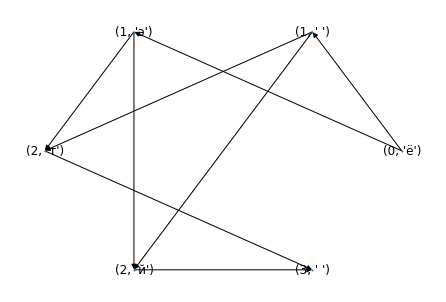

In [28]:
nx.draw_circular(build_graph(decoded_ngrams), with_labels=True, node_size=1)

На основе собранный статистике по n-граммам строится языковая модель. Она используется для оценки того насколько правдоподобен вариант дешифровки в beam search при обходе графа, начиная с первого символа. Одновременно отслеживаются заданное число наиболее вероятных гипотез дешифровки (beam_search_width - параметр алгоритма).

In [29]:
encoded_text, original_processed = encode_text(test_text, symmetric_key, n_gram=n_gram)

Encoded text length: 376


In [30]:
decoding_proposals = decode_text(encoded_text, bigram_stat, n_gram, beam_search_width=20)

Beam search:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
table_data = []
for serach_res in decoding_proposals:
    table_data.append([serach_res.log_likelihood, original_processed, serach_res.phrase])

In [32]:
display(HTML(tabulate(table_data, headers=["Логаримф правдоподобия (больше лучше)", "Оригинальный текст", "Перевод"], numalign="left", tablefmt='html')))

Логаримф правдоподобия (больше лучше),Оригинальный текст,Перевод
-349.189,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н на знда кылгл
-349.201,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х чиби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н на знда кылгл
-349.205,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждролао ыйхачутьм е цее ондесьра н на знда кылгл
-349.217,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щеа знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х чиби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждролао ыйхачутьм е цее ондесьра н на знда кылгл
-349.222,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания,быщамечимекреррео и диылрираз дарабыканадабеордамионнаакё я госоькраота у цух аллиц фрра са муылглесмабетомо пйсылме ве ц кипошьшлтии фабох неъюитвоалатъетьцичакоеныхбазнщеи лехаыхкам щее знз болем ва вхал аль этбыерь быщао неужкаалдегобузджетодоыйи х киби ви даоть оратлаъетьрае ы м доресеилергобускм удмижеенрае ы м е чту ы и ждрол о ыйхачутьм е цее ондесьра н на знда кылгл
-349.222,российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых коле

# 3 Декодирование с помощью MCMC

Оригинальная идеи были взяты из следующих статей:


Основная идея, которая была применена.

Мы знаем заранее или предполагаем, что в зашифрованном тексте каждый символ шифрованного текста соответствует какому-то символу исходного текста. Формально нам нужно найти соответствие между символами алфавита в зашифрованном сообщении и исходном. Если предположить для начала, что каждый символы соответствуют другому в порядке сортировки т. е. сортируем символы алфавита и ставим соответствия на основе их позиции. Для того чтобы найти ключ дешифрования нам необходимо найти нужную перестановку символов исходного или зашифрованного алфавита при неизменных позициях символов противоположного алфавита.

Таким образом, образуется пространство состояний с конечным множество состояний, состоящее из всевозможных перестановок символов алфавита длинной N. Чтобы найти шифр нужно найти "оптимальное" состояние.

Для перехода между состояниями предлагается использовать алгоритм Метрополиса-Гастингса. Мы генерируем новое состояние (перестановку в нашем случае), оцениваем насколько она улучшает результат дешифрования и принимаем решение о принятии нового состояние.

Для оценки того насколько "оптимально" новое состояние (перестановка $\pi$) в статьях предлагается использовать следующий критерий:
$$
Q(\pi) = \prod_{i=1}^{L-n + 1} c(x_i, x_{i+1}, \ldots, x_{i+n-1})^{c_{\pi}(x_i, x_{i+1}, \ldots, x_{i+n-1})},
$$
где $L \in \mathbb{N} -$ длина зашифрованного текста в символах, $n \in \mathbb{N}-$ это параметр модели для n-грамм (при $n=2$ получаем модель на основе биграмм), $c(\cdot)-$ сколько раз последовательность $n-$грамм встречается в базовом корпусе текстов исходного алфавита после дешифрования текста с помощью перестановки $\pi$, $ c_{\pi}(\cdot)$- сколько раз последовательность $n-$грамм встречается в тексте после его дешифрования с помощью перестановки $\pi$.

Базовый корпус это какой-то набор текстов на языке исходного алфавита, предназначенный для расчёта статистик $n-$ грамм и построения языковой модели.

Для избежания проблем с численной неустойчивостью при расчётах имеет смысл перейти к $\log Q(\pi) $:
$$
\log Q(\pi) = \sum_{i=1}^{L-n + 1} c_{\pi}(x_i, x_{i+1}, \ldots, x_{i+n-1}) \cdot \log c(x_i, x_{i+1}, \ldots, x_{i+n-1})
$$ 

Имея критерий оценки перестановок мы можем воспользоваться алгоритмом Метрополиса-Гастингса для генерации новой перестановки и вычисления вероятности её принятия в качестве нового состояния. 

Новые перестановки генерируются достаточно просто. Необходимо случайным образом поменять два элемента в текущей перестановке. Это сделано специально, чтобы перестановки не сильно отличались друг от друга в пространстве состояний и мы не совершали слишком больших переходов.

Базовый алгоритм примерно следующий: 

1. Генерируем новую перестановку $\pi^\prime $ из $ \pi $.
2. Генерируем случайную величину $u$ с равномерным распределением на $[0;1]$.
3. Считаем вероятность принятия новой перестановки. Если $ \log u < p \cdot \left( \log Q(\pi^\prime) - \log Q(\pi) \right) $, то принимаем новую перестановку $\pi^\prime$, иначе остаёмся со старой перестановкой $\pi$.

Для нахождения нужной перестановки шаги 1-3 повторяются $ Iter \in \mathbb{N} $ раз. $p > 0-$ это параметр, который влияет на вероятность принятия новой перестановки. По умолчанию его можно сделать равным 1.

Дополнительно в алгоритме используется следующая эвристика: после работы алгоритма перестановка с максимальным значением $Q(\cdot)$ возвращается в качестве результата.

In [33]:
enc_mapping = symmetric_key.get_encode_mapping()

In [34]:
encoded = "".join(map(lambda x: enc_mapping[x], original_processed))

In [35]:
original_processed

'российский физик александр попов продемонстрировал новейший прибор предназначенный для показывания быстрых колебаний в атмосферном электричестве именно этот день считается днем рождения радиоприемника в разных городах россии студенты профильных технических вузов отмечают этот праздник также с профессиональным праздником поздравляют всех работников сферы связи и радиовещания'

In [36]:
encoded

'❓👰💠💠🍡📴💠👧🍡📴👴👖🍡👂🍡👧👴🔸💅🐢👧💠🔸🆑⏫❓👴🚸👰🚸👰🔮👴🚸❓👰⏫🐢🌚👰🆑💠🚦❓🍡❓👰🔮🔸💅👴🆑👰🔮🐢📴🍸🍡📴👴🚸❓🍡🎪👰❓👴🚸❓🐢⏫🆑🔸👂🆑🔸🌱🐢🆑🆑🚛📴👴⏫💅✅👴🚸👰👧🔸👂🚛🔮🔸🆑🍡✅👴🎪🚛💠🚦❓🚛🎱👴👧👰💅🐢🎪🔸🆑🍡📴👴🔮👴🔸🚦🌚👰💠👖🐢❓🆑👰🌚👴🚳💅🐢👧🚦❓🍡🌱🐢💠🚦🔮🐢👴🍡🌚🐢🆑🆑👰👴🚳🚦👰🚦👴⏫🐢🆑🚗👴💠🌱🍡🚦🔸🐢🚦💠✅👴⏫🆑🐢🌚👴❓👰💟⏫🐢🆑🍡✅👴❓🔸⏫🍡👰🚸❓🍡🐢🌚🆑🍡👧🔸👴🔮👴❓🔸👂🆑🚛🎱👴🏦👰❓👰⏫🔸🎱👴❓👰💠💠🍡🍡👴💠🚦🔐⏫🐢🆑🚦🚛👴🚸❓👰👖🍡💅🚗🆑🚛🎱👴🚦🐢🎱🆑🍡🌱🐢💠👧🍡🎱👴🔮🔐👂👰🔮👴👰🚦🌚🐢🌱🔸🗻🚦👴🚳🚦👰🚦👴🚸❓🔸👂⏫🆑🍡👧👴🚦🔸👧💟🐢👴💠👴🚸❓👰👖🐢💠💠🍡👰🆑🔸💅🚗🆑🚛🌚👴🚸❓🔸👂⏫🆑🍡👧👰🌚👴🚸👰👂⏫❓🔸🔮💅✅🗻🚦👴🔮💠🐢🎱👴❓🔸🎪👰🚦🆑🍡👧👰🔮👴💠👖🐢❓🚛👴💠🔮✅👂🍡👴🍡👴❓🔸⏫🍡👰🔮🐢🐏🔸🆑🍡✅'

In [37]:
possible_decodings = []
for i in range(5):
    possible_decodings.append(mcmc_decryption(encoded, bigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), 30_000, generator=RND_GENERATOR))

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

In [38]:
possible_decodings.sort(key=lambda x: x.log_score, reverse=True)

In [39]:
headers = ["Логаримф оценки правдоподобности текста", "Перевод", "Перестановка"]
display(HTML(tabulate(possible_decodings, headers=headers, numalign="left", tablefmt='html')))

Логаримф оценки правдоподобности текста,Перевод,Перестановка
3318.81,российский чизик александр попов продемонстрировал новейций прибор предназнашенный для показывания быстрых колебаний в атмосчерном электришестве именно этот день сшитается днем рождения радиоприемника в разных городах россии студенты прочильных технишеских вузов отмешают этот праздник также с прочессиональным праздником поздравляют всех работников счеры связи и радиовещания,<utils.LetterPermutation object at 0x000001CA69C5E4F0>
3265.02,нассийский чигик обексордн зазал знадеварстниналоб ралейций знипан знедрогрошерруй дбя закогулория пустнум кабепорий л отвасченрав эбектнишестле иверра этат деры сшитоется древ наждерия нодиазниеврико л ногрум фанадом нассии стьдерту значибырум темришеским льгал атвешоют этат зногдрик токже с значессиаробырув зногдрикав загднолбяют лсем нопатрикал счену сляги и нодиалехория,<utils.LetterPermutation object at 0x000001CA69C34E20>
3262.59,нассийслий чигил обелсордн зазав знадекарстнинавоб равейций знипан знедрогрошерруй дбя залогувория пустнум лабепорий в откасченрак эбелтнишестве икерра этат деры сшитоется дрек наждерия нодиазниекрило в ногрум фанадом нассии стьдерту значибырум темришеслим вьгав аткешоют этат зногдрил толже с значессиаробырук зногдрилак загдновбяют всем нопатрилав счену свяги и нодиавехория,<utils.LetterPermutation object at 0x000001CA6A4015B0>
3129.99,орссеюсмею шедем нятмсниво прпра порвтурискоеораня иратющею поегро потвиндинчтиилю вяй прмндланией глсколь мрятгниею а нкурсштоиру бятмкоечтскат еутиир бкрк втиж счекнтксй виту орывтией онверпоетуиемн а ондиль фрорвнь орссее скзвтикл поршеяжиль ктьиечтсмеь аздра ркутчнцк бкрк пондвием кнмыт с порштссериняжилу пондвиемру прдвонаяйцк асть онгркиемра сштол сайде е онвератхнией,<utils.LetterPermutation object at 0x000001CA6A376820>
3027.14,тессвьсзвьохвавзону зснидточечемочтед кеисртвтемнуоием ьцвьочтвшеточт динаиня иильодупочезналмнивпошлсртлгозеу шнивьомонркесх тиекобу зртвя срм овк ииеобрерод ижосяврн рсподи котейд ивпотндвечтв кивзномотнаилгощетеднготессввосрюд ирлочтехвужилгор гивя сзвгомюаемоерк яныробрерочтнадивзорнзй осочтех ссвеинужилкочтнадивзекочеадтнмупыромс готншеривземосх тлосмпавовотндвем энивп,<utils.LetterPermutation object at 0x000001CA6A376700>


# 4 Расшифровка тестового текста

## 4.1 Расшифровка на основе биграмм

In [40]:
input_text = "←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏"

In [41]:
len(set(input_text))

28

Попробуем расшифровать текст с предположением, что он на русском языке.

In [42]:
original_vocab = set(RUSSIAN_LETTERS)
original_vocab.add(" ")
target_vocab = list(set(input_text))
emojii_vocab = list(get_emoji_vocab())
target_vocab += emodji_vocab[:len(original_vocab) - len(target_vocab)]
del emojii_vocab

symmetric_key = LetterPermutation(original_vocab, target_vocab)

In [43]:
print(Counter(input_text).most_common(), sep=" ")

[('↹', 34), ('←', 22), ('⇛', 22), ('↟', 15), ('⇒', 13), ('↝', 13), ('⇴', 13), ('↨', 12), ('⇠', 10), ('⇯', 8), ('↷', 7), ('⇌', 7), ('⇊', 6), ('⇞', 6), ('⇈', 5), ('⇷', 5), ('↤', 4), ('↳', 4), ('↾', 4), ('↙', 4), ('⇙', 3), ('↲', 3), ('↞', 3), ('⇆', 2), ('⇰', 2), ('⇸', 1), ('↘', 1), ('⇏', 1)]


In [44]:
possible_decodings = []
num_iters = 30_000
num_exp = 5
for scaling in [0.5, 1, 1.25]:
    print("Scaling: ", scaling, "\n")
    for i in range(num_exp):
        possible_decodings.append((scaling,) + mcmc_decryption(input_text, bigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), num_iters = num_iters
, scaling=scaling, generator=RND_GENERATOR))

Scaling:  0.5 



  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Scaling:  1 



  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Scaling:  1.25 



  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

In [45]:
possible_decodings.sort(key=lambda x: x[1], reverse=True)

In [46]:
display(HTML(tabulate(possible_decodings, headers=["Параметр масштабирования"] + headers, numalign="left", tablefmt='html')))

Параметр масштабирования,Логаримф оценки правдоподобности текста,Перевод,Перестановка
0.5,2116.44,если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж,<utils.LetterPermutation object at 0x000001CA6A3F7AC0>
1,2116.44,если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж,<utils.LetterPermutation object at 0x000001CA6A494220>
0.5,2115.08,если вы вимите нордальный или почти нордальный текст у этого сообшения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обешаж,<utils.LetterPermutation object at 0x000001CA69C533A0>
1.25,2092.77,евли сь сичине торкалытью или помни торкалытью недвн у жного вообщетия донорью легдо проминаны вдорее свего сь све вчелали прасилыто и полумине кадвикалытью балл за повлечтее менсерное зачатие дурва хоня дотемто я тимего те обещаш,<utils.LetterPermutation object at 0x000001CA6A41C850>
0.5,2092.56,евли сь сичине торкалытью или помни торкалытью недвн у жного вообщетия донорью легдо проминаны вдорее свего сь све вчелали прасилыто и полумине кадвикалытью балл за повлечтее менсерное зачатие дурва хоня дотемто я тимего те обещай,<utils.LetterPermutation object at 0x000001CA69C53AF0>
0.5,2090.74,ерли пы пимите новзальный или содти новзальный текрт у этого рообщения котовый легко сводитать рковее прего пы пре рмелали свапильно и солудите закризальный балл ча сорлемнее детпевтое чамание кувра хотя конедно я нидего не обещаж,<utils.LetterPermutation object at 0x000001CA69C53AC0>
0.5,2083.62,ерни пь пимите лосканылью ини вочти лосканылью тедрт у этого рообщелия дотосью негдо всочитаты рдосее прего пь пре рменани всапиныло и вонучите кадриканылью банн за ворнемлее четпестое замалие дусра хотя долечло я личего ле обещаж,<utils.LetterPermutation object at 0x000001CA6A390280>
1,2073.05,евли ду дишине корчалькую или помни корчалькую нетвн с жного вообщекия тонорую легто проминань вторее двего ду две вшелали прадилько и полсмине чатвичалькую балл за повлешкее мендерное зашакие тсрва хоня токемко я кимего ке обещай,<utils.LetterPermutation object at 0x000001CA6A42BA60>
1.25,2072,ерни пл пишите восманывль ини кочти восманывль тедрт у этого рообщевия дотосль негдо ксочитаты рдосее прего пл пре ршенани ксапиныво и конучите мадриманывль банн за корнешвее четпестое зашавие дусра хотя довечво я вичего ве обещаж,<utils.LetterPermutation object at 0x000001CA6A53DEB0>
1.25,2071.08,отви сь сидино леркавылью иви пегни леркавылью ночтн у жнеме теебхолия ченерью вомче прегинаны тчероо стоме сь сто тдовави прасивыле и певугино качтикавылью бавв за петводлоо гонсорнео задалио чурта шеня челогле я лигоме ло ебохай,<utils.LetterPermutation object at 0x000001CA6A538B20>


## 4.2 Расшифровка на основе триграмм 

In [47]:
n_gram = 3
source_freq = Counter()
for name in texts:
    source_freq.update(count_ngram(texts[name], n_gram=n_gram))

In [48]:
trigram_stat = NGramStat(source_freq)

In [49]:
possible_decodings = []
num_iters = 8_000
num_exp = 5
for scaling in [0.25, 1, 10, 100]:
    print("Scaling: ", scaling, "\n")
    for i in range(num_exp):
        possible_decodings.append((scaling,) + mcmc_decryption(input_text, trigram_stat, symmetric_key.src_vocab(), symmetric_key.chiper_vocab(), num_iters=num_iters, scaling=scaling, generator=RND_GENERATOR))

Scaling:  0.25 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  1 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  10 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Scaling:  100 



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [50]:
possible_decodings.sort(key=lambda x: x[1], reverse=True)

In [51]:
display(HTML(tabulate(possible_decodings, headers=["Параметр масштабирования"] + headers, numalign="left", tablefmt='html')))

Параметр масштабирования,Логаримф оценки правдоподобности текста,Перевод,Перестановка
10,1608.44,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x000001CA6A498130>
1,1605.18,если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаж,<utils.LetterPermutation object at 0x000001CA6A41C160>
0.25,1602.5,если вы видите норжальный или почти норжальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите жаксижальный балл за последнее четвертое задание курса мотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x000001CA6A4831F0>
1,1602.5,если вы видите норжальный или почти норжальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите жаксижальный балл за последнее четвертое задание курса мотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x000001CA6A4CD370>
0.25,1600.81,если вы видите норжальный или почти норжальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите жаксижальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю,<utils.LetterPermutation object at 0x000001CA6A3E2CD0>
100,1574.08,есла вы вадате нормильный ала пошта нормильный текст у чтого сообщеная который легко прошатить скорее всего вы все сделила привально а полушате миксамильный билл жи последнее шетвертое жидинае курси хотя конешно я нашего не обещиц,<utils.LetterPermutation object at 0x000001CA6A483250>
1,1554.63,если ву видите нормальную или почти нормальную текст ж этого сообщения которую легко прочитать скорее всего ву все сделали правильно и полжчите максимальную балл за последнее четвертое задание кжрса хотя конечно я ничего не обещай,<utils.LetterPermutation object at 0x000001CA6A456580>
100,1489.18,если вы видите нархольный или пачти нархольный текст у этаза саамбения катарый лезка прачитоть скарее всеза вы все сделоли провильна и палучите хоксихольный молл го паследнее четвертае годоние курсо жатя канечна я ничеза не амебою,<utils.LetterPermutation object at 0x000001CA6A44E490>
0.25,1395.83,идна зь зачали торженятью ана повла торженятью лигдл у шлосо дообщитак голорью нисго провалеля дгории здисо зь зди дчинена презанято а понували жегдаженятью бенн ме подничтии вилзирлои мечетаи гурде холк готивто к тависо ти обищеы,<utils.LetterPermutation object at 0x000001CA6A3E2D00>
10,1394.17,енси му мибите лоржасклую иси подти лоржасклую тевнт ы этого ноочшелия воторую сегво продитатк нворее мнего му мне нбесаси прамискло и посыдите жавнижасклую часс за понсеблее детмертое забалие вырна хотя воледло я лидего ле очешай,<utils.LetterPermutation object at 0x000001CA6A4CDE50>


# 5 Бонус Сравнение разных параметров

Все метрики были получены с помощью скрипта `metrics.py`. Разные куски корпуса `AnnaKarenina.txt` выступали в качестве теста. Корпус `WarAndPeace.txt` использовался для расчёта статистик.

В качестве метрики `accuracy` выступала доля правильных совпадений между символами алфавита после расшифровки.

In [108]:
metric_path = pathlib.Path("data", "metrics.csv.gz")

In [109]:
metric_data = pd.read_csv(metric_path)

In [110]:
metric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   exp_id       1350 non-null   int64  
 1   num_run      1350 non-null   int64  
 2   n_gram       1350 non-null   int64  
 3   num_iter     1350 non-null   int64  
 4   scaling      1350 non-null   float64
 5   text_length  1350 non-null   int64  
 6   accuracy     1350 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 74.0 KB


In [111]:
metric_data.head()

,exp_id,num_run,n_gram,num_iter,scaling,text_length,accuracy
0,0,0,2,2000,0.5,2168,0.823529
1,0,1,2,2000,0.5,2168,0.411765
2,0,2,2,2000,0.5,2168,0.558824
3,0,3,2,2000,0.5,2168,0.088235
4,0,4,2,2000,0.5,2168,0.176471


При расшифровке тестового текста наилучшим образом показали себя триграммы. В целом по метрикам триграммы показывают наилучшие результаты. На практике имеет смысл выбирать между биграммами и триграммами.  Большее число n-грамм уже даёт результаты похуже.

In [119]:
ex.histogram(metric_data, x="accuracy", color="n_gram", marginal="box", title="Доля правильно расшифрованных символов при разном числе n-грамм")

Как правило, при увеличении длины текста качество также растёт. Это связано с тем что становится доступно больше статистики о распределение символов в закодированном тексте и соответственно можно более точно сопоставить с распределением слов в базовом корпусе.

In [98]:
text_acc = metric_data.groupby(["text_length", "n_gram"], as_index=False).agg({"accuracy": "mean"})
text_acc["n_gram"] = text_acc["n_gram"].astype(str)

In [99]:
ex.scatter(text_acc, x="text_length", y="accuracy", color="n_gram", title="Значение средней точности расшифровки символов от длины текста")

При небольшом числе итераций в среднем триграммы показывают себя лучше биграмм. При увеличении числа итераций точность растёт, хотя для n-грамм при $n=4$ наблюдается просадка по точности.

In [101]:
num_iter = metric_data.groupby(["num_iter", "n_gram"], as_index=False).agg({"accuracy": "mean"})
num_iter["n_gram"] = num_iter["n_gram"].astype(str)

In [102]:
ex.scatter(num_iter, x="num_iter", y="accuracy", color="n_gram", title="Значение средней точности расшифровки символов от числа итераций")

Коэффициент масштабирования $r$ иногда может влиять на результат. В некоторых случаях его увеличение приводит к повышению качества декодирования, но как показано в статьях при дальнейшем увеличении этого параметра качество может упасть. На практике он позволяет контролировать насколько сильно алгоритм будет исследовать новые состояние. В каких-то сложных случаях большие значения могут быть полезны.

In [104]:
scaling_acc = metric_data.groupby(["scaling", "n_gram"], as_index=False).agg({"accuracy": "mean"})
scaling_acc["n_gram"] = scaling_acc["n_gram"].astype(str)

In [117]:
ex.scatter(scaling_acc, x="scaling", y="accuracy", color="n_gram", title="Значение средней точности расшифровки символов от r")

# 6 Бонус. Применения MCMC

Я думаю, что аналогичные подходы как с расшифровкой текста можно применить в генетике. Например, для расшифровки последовательности геномов или что-то аналогично, когда уже есть база известных расшифровок. 

Для добавления дополнительных эвристик в уже существующие алгоритмы. Пространство состояний может быть в обучении RL-агентов. Нам необходимо их исследовать с учётом того что известна оценка того насколько это состояние "оптимально".